# Table of Contents

- [Libraries](#Libraries)
- [Data](#Data)
-[Multicolinearity](#Multicolinearity)
- [Modeling](#Modeling)
    - [K-Means](#K-Means)

# Libraries 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN, KMeans, k_means
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.feature_selection import SelectKBest
from sklearn import metrics
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings('ignore')

# Data

In [2]:
pitch_data = pd.read_csv('../datasets/mlb_pitch_stats_19_20_21.csv', index_col= ['player_id'])
pitch_data.drop(columns = ['Unnamed: 0',' first_name', 'last_name'], axis = 1, inplace = True)
print(pitch_data.shape)
pitch_data.head()

(1072, 86)


,year,age,ip,bf,ab,h,k%,bb%,ba,slg%,...,cb_brk,cb_velo_range,cu%,cu_velo,cu_spinrate,cu_hb,cu_vb,cu_brk,cu_velo_range,xops
player_id,,,,,,,,,,,,,,,,,,,,,
425794,2021,40,196.1,784,725,157,21.6,5.9,0.217,0.343,...,22.3,1.6,22.2,85.0,2408.0,6.3,-31.0,9.5,1.6,0.681
425844,2021,38,164.2,670,626,157,17.0,5.2,0.251,0.431,...,15.6,2.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.725
429722,2021,39,61.1,255,232,58,18.8,7.5,0.250,0.444,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.851
433589,2021,37,72.1,290,273,63,12.4,4.1,0.231,0.399,...,10.7,1.8,23.3,84.5,2133.0,-1.1,-21.1,17.3,1.3,0.722
445276,2021,34,61.2,250,210,33,29.6,13.6,0.157,0.233,...,0.0,0.0,57.1,92.5,2689.0,7.3,-14.4,19.2,1.9,0.570


# Multicolinearity

In [3]:
def calc_vif(pitch_data):
    vif_data = pd.DataFrame()
    vif_data['features'] = pitch_data.columns
    vif_data['VIF'] = [variance_inflation_factor(pitch_data.values, i) 
                       for i in range(len(pitch_data.columns))]
    return(vif_data.sort_values(by = 'VIF'))

calc_vif(pitch_data)

,features,VIF
15,cg,1.364100e+00
1,age,1.365355e+00
81,cu_hb,1.527192e+00
41,edge%,1.624982e+00
29,solid_contact%,1.835575e+00
...,...,...
40,in_zone%,7.116449e+06
37,out_zone%,8.169750e+06
17,xslg,inf
20,xobp,inf


# Modeling

In [4]:
pitch_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1072 entries, 425794 to 685493
Data columns (total 86 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   year              1072 non-null   int64  
 1   age               1072 non-null   int64  
 2   ip                1072 non-null   float64
 3   bf                1072 non-null   int64  
 4   ab                1072 non-null   int64  
 5   h                 1072 non-null   int64  
 6   k%                1072 non-null   float64
 7   bb%               1072 non-null   float64
 8   ba                1072 non-null   float64
 9   slg%              1072 non-null   float64
 10  obp%              1072 non-null   float64
 11  ops               1072 non-null   float64
 12  earned_runs       1072 non-null   int64  
 13  era               1072 non-null   float64
 14  qual_start        1072 non-null   int64  
 15  cg                1072 non-null   int64  
 16  xba               1072 non-null   f

### K-Means

In [5]:
ss = StandardScaler()
X_scaled = ss.fit_transform(pitch_data)

In [6]:
km = KMeans(n_clusters = 5,
            init = 'random',
            random_state = 42)

km.fit(X_scaled)
label = km.fit_predict(X_scaled)

print(label)

[2 2 3 ... 3 4 3]


In [7]:
pitch_data['label'] = label
pitch_data.head()

,year,age,ip,bf,ab,h,k%,bb%,ba,slg%,...,cb_velo_range,cu%,cu_velo,cu_spinrate,cu_hb,cu_vb,cu_brk,cu_velo_range,xops,label
player_id,,,,,,,,,,,,,,,,,,,,,
425794,2021,40,196.1,784,725,157,21.6,5.9,0.217,0.343,...,1.6,22.2,85.0,2408.0,6.3,-31.0,9.5,1.6,0.681,2
425844,2021,38,164.2,670,626,157,17.0,5.2,0.251,0.431,...,2.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.725,2
429722,2021,39,61.1,255,232,58,18.8,7.5,0.250,0.444,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.851,3
433589,2021,37,72.1,290,273,63,12.4,4.1,0.231,0.399,...,1.8,23.3,84.5,2133.0,-1.1,-21.1,17.3,1.3,0.722,1
445276,2021,34,61.2,250,210,33,29.6,13.6,0.157,0.233,...,0.0,57.1,92.5,2689.0,7.3,-14.4,19.2,1.9,0.570,0


In [8]:
centroids = km.cluster_centers_

print('Number of Centroids:', len(centroids))
print("Predicted clusters to points: ", label[:10], '\n')
print("Location of centroids: ")
print(centroids)

Number of Centroids: 5
Predicted clusters to points:  [2 2 3 1 0 1 1 2 3 0] 

Location of centroids: 
[[ 7.03536523e-02  1.53451992e-01 -4.98669797e-01 -5.22335720e-01
  -5.27276554e-01 -6.17087155e-01  7.46892764e-01  3.49669183e-01
  -7.10921138e-01 -7.17849854e-01 -4.08328244e-01 -6.67053164e-01
  -6.49506045e-01 -5.39455024e-01 -5.33135611e-01 -2.82303327e-01
  -8.33929576e-01 -8.00837505e-01 -6.34210565e-01 -7.11252356e-01
  -4.46292700e-01 -3.85326345e-01 -4.88095530e-01 -3.21408030e-01
  -4.57837956e-01 -1.11309890e-01 -1.04765887e-03 -3.08409222e-01
  -3.51228657e-01 -3.47153756e-03 -6.27821287e-02 -2.01523453e-01
  -8.64406289e-02  5.72701948e-01  2.44148190e-01  7.55218812e-01
  -7.46222791e-01  1.07272414e-01 -5.07268904e-01 -5.71603597e-01
  -1.07272414e-01 -5.05268916e-01  8.02317911e-01  5.46139416e-02
   4.37159943e-02 -7.09282879e-02 -1.14667545e-01  1.75832393e-01
   7.91333363e-02 -5.09148785e-01  4.87013448e-02 -1.60545623e-02
  -6.59071238e-03 -4.74856734e-02  2.028

In [9]:
len(km.labels_)

print('label:', km.labels_)
print('Number of iterations:', km.n_iter_)
print('Number of features:', km.n_features_in_)
print('Number of clusters:', km.n_clusters)
print('Inertia:', km.inertia_)
print('Silhouette Score:', silhouette_score(X_scaled, label))

label: [2 2 3 ... 3 4 3]
Number of iterations: 37
Number of features: 86
Number of clusters: 5
Inertia: 68665.52337023166
Silhouette Score: 0.0938718952605312


In [10]:
score = silhouette_score(pitch_data, label)
print('Silhouette Score:', score)

Silhouette Score: 0.11731940907932364


In [11]:
pitch_data.groupby(by = 'label').mean().T

label,0,1,2,3,4
year,2020.030864,2019.969543,2019.918033,2019.966805,2019.986159
age,29.574074,29.558376,29.256831,28.477178,28.622837
ip,49.559259,62.866497,156.455738,56.970539,53.451211
bf,207.932099,270.624365,655.311475,255.410788,221.273356
ab,184.012346,242.984772,595.557377,226.991701,197.608997
...,...,...,...,...,...
cu_hb,0.430864,0.913198,0.445902,0.279668,0.139792
cu_vb,-5.982099,-21.553299,-11.432240,-4.717842,-3.763668
cu_brk,2.098765,7.117766,3.892896,1.863071,1.205190
cu_velo_range,0.315432,1.168020,0.634426,0.257261,0.210727


In [12]:
filtered_label0 = pitch_data.iloc[label == 0]
filtered_label1 = pitch_data.iloc[label == 1]
filtered_label2 = pitch_data.iloc[label == 2]
filtered_label3 = pitch_data.iloc[label == 3]
filtered_label4 = pitch_data.iloc[label == 4]

In [13]:
centroids_x = centroids[0:,:1]
centroids_y = km.cluster_centers_[:,1:2]

print('x:', centroids_x)
print('\n')
print('y:', centroids_y)

x: [[ 0.07035365]
 [-0.00535514]
 [-0.06895137]
 [-0.00873577]
 [ 0.01515949]]


y: [[ 0.15345199]
 [ 0.14915091]
 [ 0.06653314]
 [-0.14707715]
 [-0.10716929]]


In [14]:
cluster = pitch_data[['la_avg', 'cb_spinrate']]

ValueError: 'c' argument has 1072 elements, which is inconsistent with 'x' and 'y' with size 86.

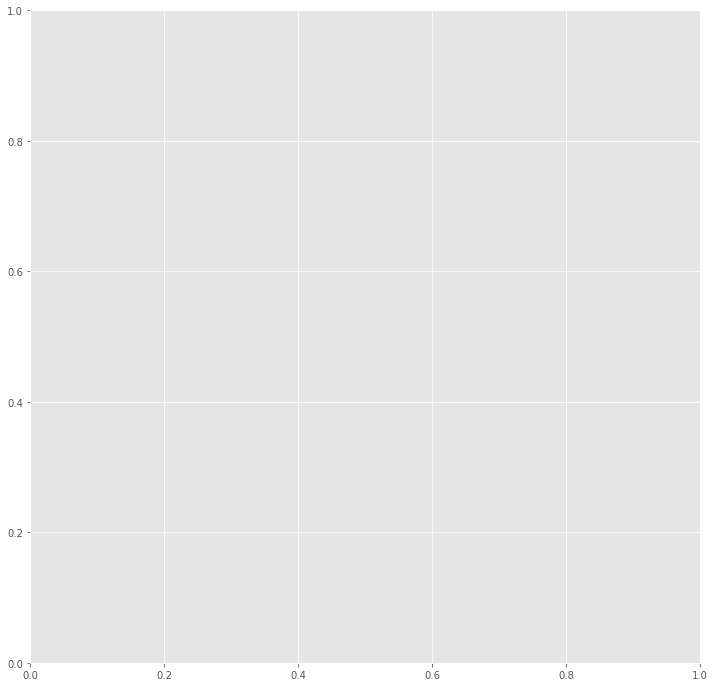

In [15]:
plt.figure(figsize=(12,12))

plt.scatter(x = X_scaled[0], y = X_scaled[1], 
            c = km.labels_);
plt.scatter(centroids_x, centroids_y, 
            marker = 'o', s=100, 
            linewidths = 5);

In [ ]:
plt.scatter(centroids_x, centroids_y, 
            marker='o', s=150, 
            linewidths = 5);

In [ ]:
print(len(centroids_x))
print(len(centroids_y))

In [ ]:
u_labels = np.unique(label)
plt.figure(figsize = (12, 12))

for i in u_labels:
    plt.scatter(X_scaled[label == i , 0], X_scaled[label == i , 1], label = i);
    plt.legend();
plt.show();

In [ ]:
pitch_data.columns

In [ ]:
X_variables = pitch_data.copy()

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_data = pd.DataFrame(index = 1)
vif_data["feature"] = X_variables
vif_data["VIF"] = [variance_inflation_factor(X_variables.values, i) 
                   for i in range(len(X_variables))]
print(vif_data)